In [1]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import glob
import cv2
import pathlib
import splitfolders
import tempfile
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    MaxPooling2D,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
)
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling

In [2]:
IMAGE_SIZE = 224
TARGET_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE2 = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_dir = './wheat_tmp'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            base_dir,
            labels = 'inferred',
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE,
            color_mode = 'rgb'
)

Found 7477 files belonging to 14 classes.


In [4]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [5]:
classes = dataset.class_names
classes

['Brown_Rust-augmented',
 'Fusarium_Head_Blight-augmented',
 'Healthy-augmented',
 'Loose_Smut-augmented',
 'Powdery_Mildew-augmented',
 'Wheat_aphid-augmented',
 'Wheat_leaf_blotch-augmented',
 'Wheat_midge-augmented',
 'Wheat_mite-augmented',
 'Wheat_rust-augmented',
 'Wheat_sawfly-augmented',
 'Wheat_scab-augmented',
 'Wheat_smut-augmented',
 'Yellow_Rust-augmented']

In [6]:
len(dataset)

468

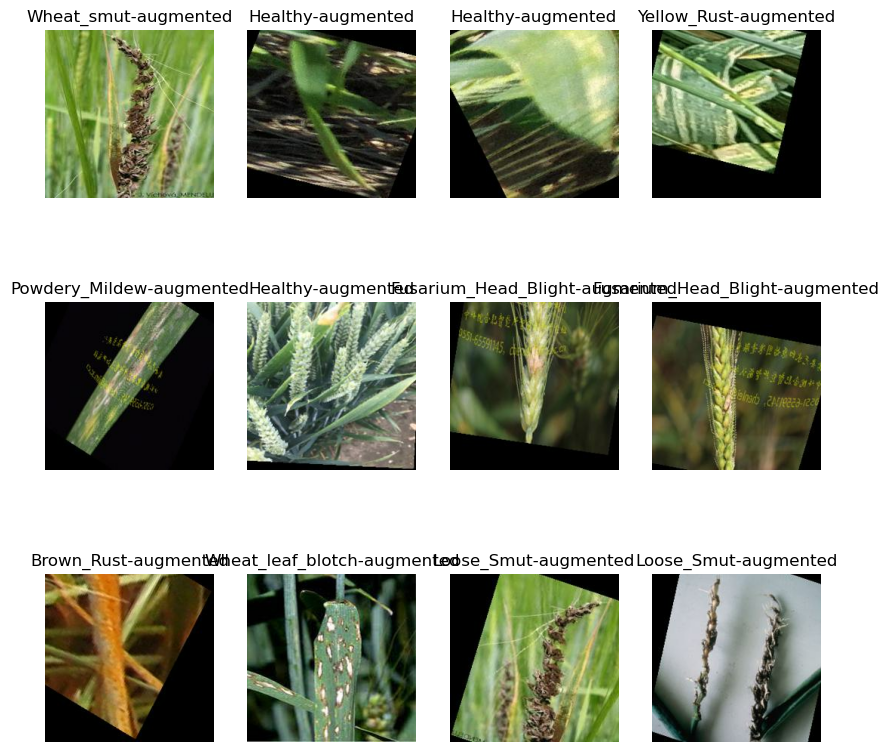

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [8]:
len(dataset) * 64

29952

In [9]:
def data_split(data, train_split = 0.8, val_split = 0.15, 
               test_split = 0.05, shuffle=True, shuffle_size = 10000):
    data_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_ds = data.take(train_size)
    val_ds = data.skip(train_size).take(val_size)
    test_ds = data.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = data_split(dataset)

In [11]:
print("Length of Training Dataset is",len(train_ds))
print("\nLength of Validation Dataset is",len(val_ds))
print("\nLength of Testing Dataset is",len(test_ds))

Length of Training Dataset is 374

Length of Validation Dataset is 70

Length of Testing Dataset is 24


## Augment Data

In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [13]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [14]:
def resize(ds):
    resizing_rescaling = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(224,224),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
    ])

    return resizing_rescaling

In [15]:
resizing_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(224,224),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255.0)
])

In [16]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                                 width_factor=(-0.3, 0.3),
                                                                 fill_mode = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                            interpolation = 'nearest'),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

    return data_augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


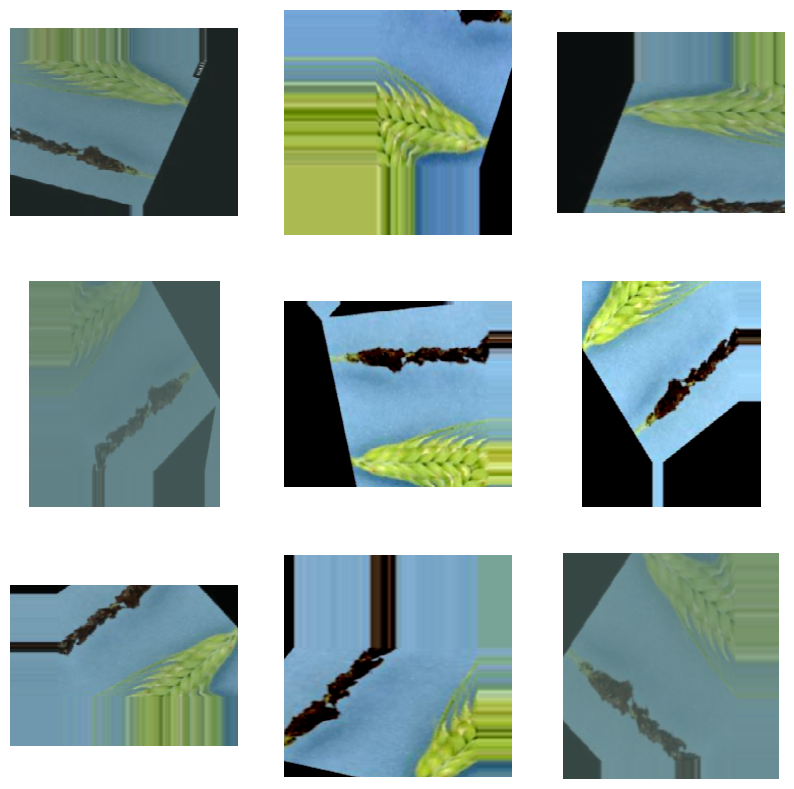

In [17]:
data_augmentation = data_augmenter()

for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [18]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.3, 0.3),
                                                             width_factor=(-0.3, 0.3),
                                                             fill_mode = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomHeight(factor=(-0.3, 0.3),
                                                        interpolation = 'nearest'),
tf.keras.layers.experimental.preprocessing.RandomContrast(0.9)
])

In [19]:
def conf_matrix(y_test, y_pred):
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

  ax.set_title('Confusion Matrix with labels\n')
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ')
  ax.set_xticks()
  ax.xaxis.set_ticklabels(source_classes, rotation=45)
  ax.yaxis.set_ticklabels(source_classes, rotation=45)

  plt.show()

## Model Resnet

In [20]:
# Get a single batch from the dataset
batch = next(iter(train_ds))

input_data = batch[0]

# Print the shape of the data in the batch
print(input_data.shape)

(16, 224, 224, 3)


In [21]:
from tensorflow.keras.applications.resnet import ResNet50

pre_trained_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
for layer in pre_trained_model.layers[-26:]:
    layer.trainable = True

In [22]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [23]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)
#x = data_augmentation(inputs)
#x = preprocess_input(x)
x = preprocess_input(inputs)
#x = data_augmentation(x)
#x = mbnet_v2(x, training=False)
x = pre_trained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
predict = tf.keras.layers.Dense(14, activation = 'softmax')(x)

model5 = tf.keras.Model(inputs = inputs, outputs = predict)
#model5 = tf.keras.Model(inputs = pre_trained_model.input, outputs = predict)

In [24]:
model5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               104908

In [25]:
class EarlyStoppingAtMaxAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True
        elif(logs.get('val_accuracy')>=0.99):
            print("\nAccuracy is high so cancelling training!")
            self.model.stop_training = True

callbacks = EarlyStoppingAtMaxAccuracy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [26]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=['accuracy']
)

In [27]:
history5 = model5.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[callbacks]
)

Epoch 1/50
374/374 [==============================] - 104s 233ms/step - loss: 0.9827 - accuracy: 0.6697 - val_loss: 0.4585 - val_accuracy: 0.8295
Epoch 2/50
374/374 [==============================] - 86s 221ms/step - loss: 0.4295 - accuracy: 0.8535 - val_loss: 0.2853 - val_accuracy: 0.9018
Epoch 3/50
374/374 [==============================] - 86s 222ms/step - loss: 0.2978 - accuracy: 0.8997 - val_loss: 0.2911 - val_accuracy: 0.9044
Epoch 4/50
374/374 [==============================] - 86s 222ms/step - loss: 0.2284 - accuracy: 0.9253 - val_loss: 0.1289 - val_accuracy: 0.9563
Epoch 5/50
374/374 [==============================] - 87s 223ms/step - loss: 0.2349 - accuracy: 0.9320 - val_loss: 0.1474 - val_accuracy: 0.9500
Epoch 6/50
374/374 [==============================] - 87s 223ms/step - loss: 0.1702 - accuracy: 0.9456 - val_loss: 0.0894 - val_accuracy: 0.9741
Epoch 7/50
374/374 [==============================] - 86s 219ms/step - loss: 0.1319 - accuracy: 0.9597 - val_loss: 0.0663 - val_a

In [28]:
model5.save('Resnet50Model_wheat.h5')

d:\Anaconda\envs\python-3-9\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [29]:
score_train = model5.evaluate(train_ds)
score_valid = model5.evaluate(val_ds)
score_test = model5.evaluate(test_ds)

24/24 [==============================] - 6s 131ms/step - loss: 0.0197 - accuracy: 0.9922


In [30]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

In [31]:
print("Accuracy: {}".format(acc[-1]))
print("Validation Accuracy: {}".format(val_acc[-1]))

print("Loss: {}".format(loss[-1]))
print("Validation Loss: {}".format(val_loss[-1]))

Accuracy: 0.9802807569503784
Validation Accuracy: 0.9901785850524902
Loss: 0.07550021260976791
Validation Loss: 0.02245611697435379


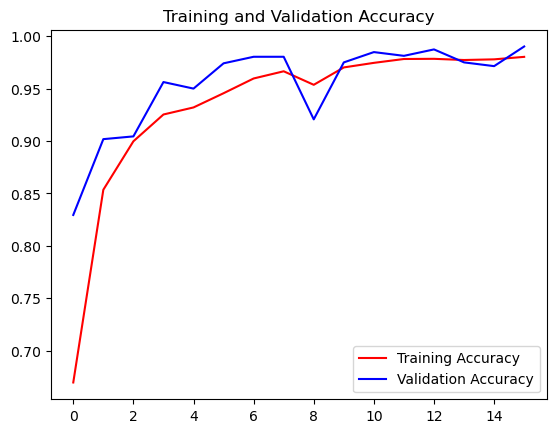

<Figure size 640x480 with 0 Axes>

In [32]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

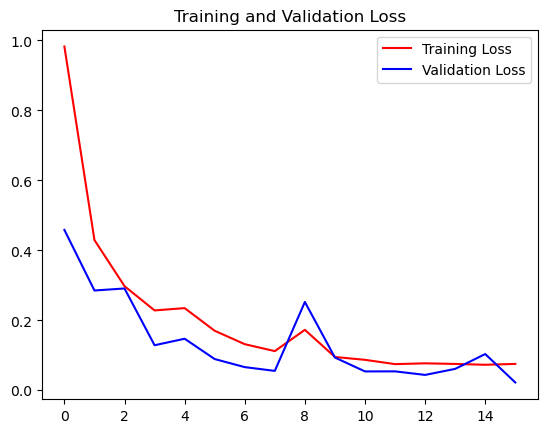

<Figure size 640x480 with 0 Axes>

In [33]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()

plt.show()

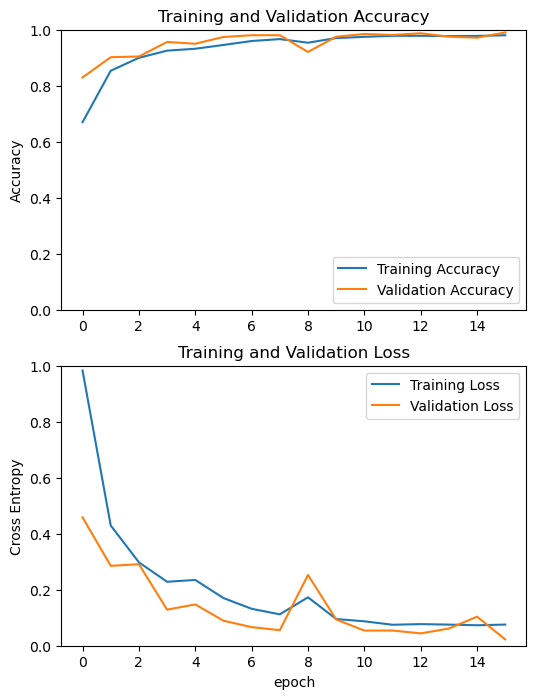

In [34]:
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to predict
actual label: Healthy-augmented
predicted label: Healthy-augmented


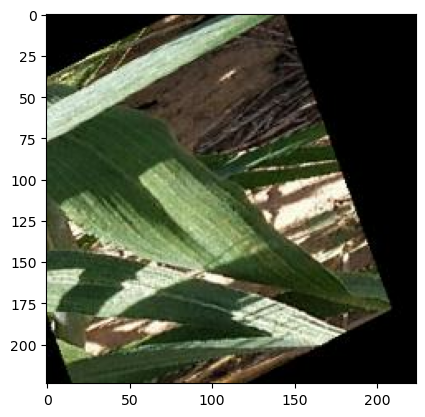

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model5.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [36]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(np.max(predictions[0]),2)
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

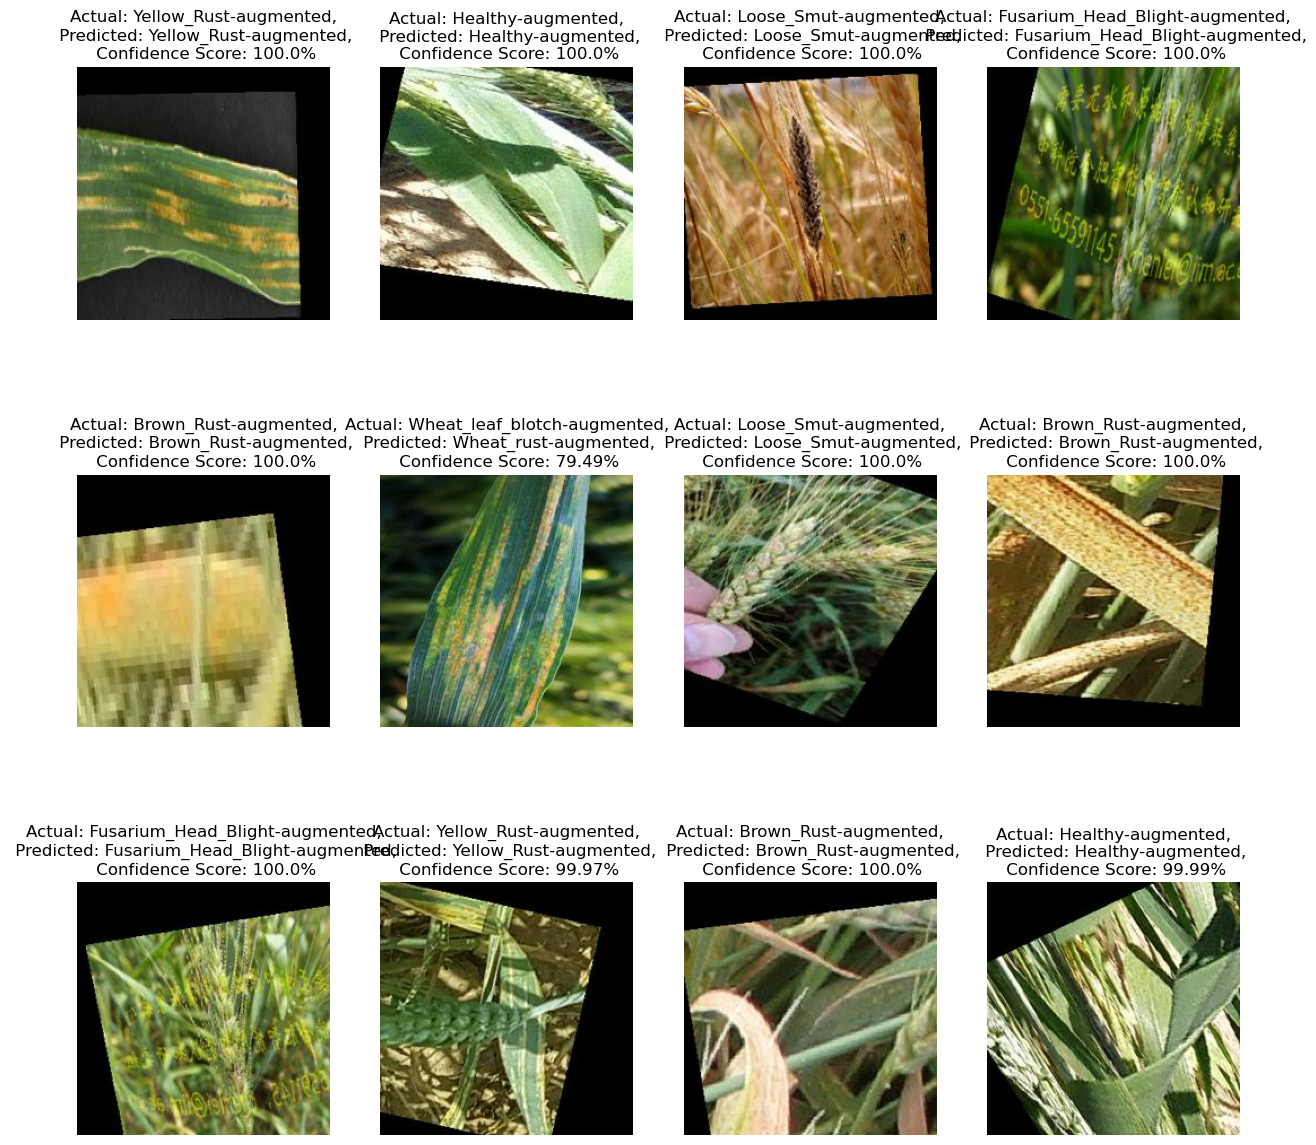

In [37]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model5,images[i].numpy())
        actual_class = classes[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [41]:
pred_class = []
act_class = []
for images, labels in test_ds:
    for i, image in enumerate(images):
        predicted_class, confidence = predict(model5, image.numpy())
        actual_class = classes[labels[i]]
        pred_class.append(predicted_class)
        act_class.append(actual_class)

In [42]:
act_class

['Yellow_Rust-augmented',
 'Brown_Rust-augmented',
 'Wheat_sawfly-augmented',
 'Brown_Rust-augmented',
 'Powdery_Mildew-augmented',
 'Fusarium_Head_Blight-augmented',
 'Powdery_Mildew-augmented',
 'Wheat_smut-augmented',
 'Brown_Rust-augmented',
 'Powdery_Mildew-augmented',
 'Loose_Smut-augmented',
 'Brown_Rust-augmented',
 'Wheat_rust-augmented',
 'Healthy-augmented',
 'Fusarium_Head_Blight-augmented',
 'Loose_Smut-augmented',
 'Fusarium_Head_Blight-augmented',
 'Wheat_leaf_blotch-augmented',
 'Brown_Rust-augmented',
 'Fusarium_Head_Blight-augmented',
 'Wheat_smut-augmented',
 'Brown_Rust-augmented',
 'Fusarium_Head_Blight-augmented',
 'Healthy-augmented',
 'Yellow_Rust-augmented',
 'Healthy-augmented',
 'Yellow_Rust-augmented',
 'Healthy-augmented',
 'Wheat_mite-augmented',
 'Brown_Rust-augmented',
 'Wheat_smut-augmented',
 'Powdery_Mildew-augmented',
 'Yellow_Rust-augmented',
 'Brown_Rust-augmented',
 'Wheat_aphid-augmented',
 'Wheat_smut-augmented',
 'Powdery_Mildew-augmented',
 'B

In [43]:
cm = confusion_matrix(act_class, pred_class, labels=classes)

In [44]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_title('Confusion Matrix with labels\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(classes, rotation=45)
    ax.yaxis.set_ticklabels(classes, rotation=45)

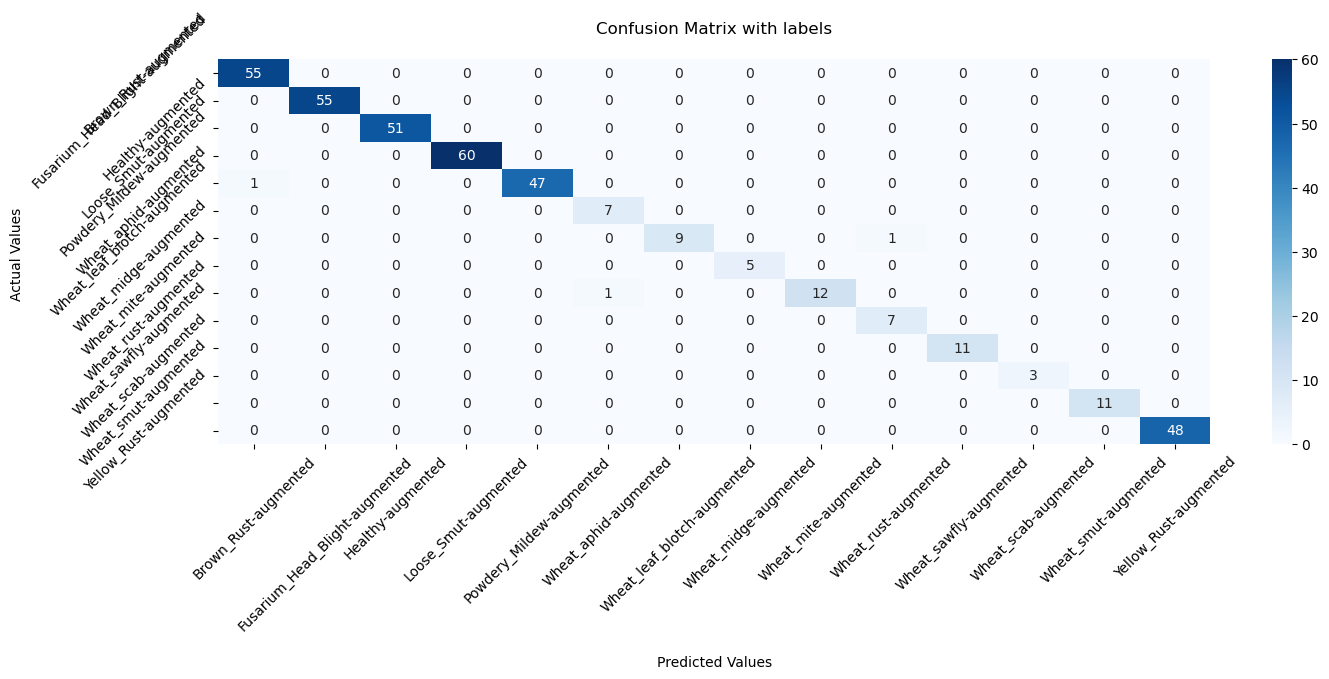

In [45]:
plot_confusion_matrix(cm = cm, classes = classes)

In [46]:
def saved_model(model_path, modelname, model):
  export_path = os.path.join(model_path, modelname)
  model.save(export_path)
  #tf.saved_model.save(model, export_path)
  print("Export path: ", export_path)
  print(os.listdir(export_path))

# function to saved_model_history
def saved_model_history(model_path, modelname, history):
  with open(os.path.join(model_path, modelname), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# function to save tflite
def tflite_model_convert(model_path, tflite_path, modelname):

  # Intialize the TFLite converter to load the SavedModel
  export_path = os.path.join(model_path, modelname)

  converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

  # Set the optimization strategy in the converter 
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  # Use the tool to finally convert the model
  tflite_model = converter.convert()

  # Write TFLite model
  tflite_dir = os.path.join(tflite_path, "{}".format(modelname))

  os.mkdir(tflite_dir)

  tflite_file = os.path.join(tflite_dir, "{}.tflite".format(modelname))
  
  label_file = os.path.join(tflite_dir, "{}.txt".format(modelname))

  with open(tflite_file, "wb") as f:
      f.write(tflite_model)

  with open(label_file, 'w') as f:
      f.write('\n'.join(classes))

  print("Export path: ", tflite_dir)
  print(os.listdir(tflite_dir))

In [47]:
model5.save('Resnet50Model_Wheat_v1.h5')

d:\Anaconda\envs\python-3-9\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
